In [1]:
1+1

2

# 1. Backpropagation from scratch (single Neuron)

inspired from [Andrej Kalapathy's micrograd](https://www.youtube.com/watch?v=VMj-3S1tku0&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=2)

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return x**2 - 2*x + 1

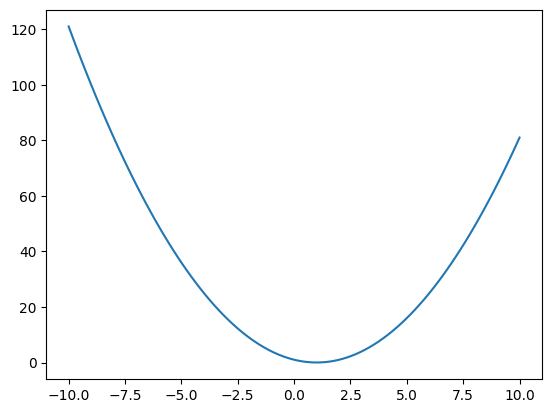

In [7]:
x = np.linspace(-10, 10, 100)
y = f(x)
plt.plot(x, y)

In [44]:
def sigmoid_fun(x):
    return 1 / (1 + np.exp(-x)) 

def sigmoid_derivative(x):
    return sigmoid_fun(x) * (1 - sigmoid_fun(x))

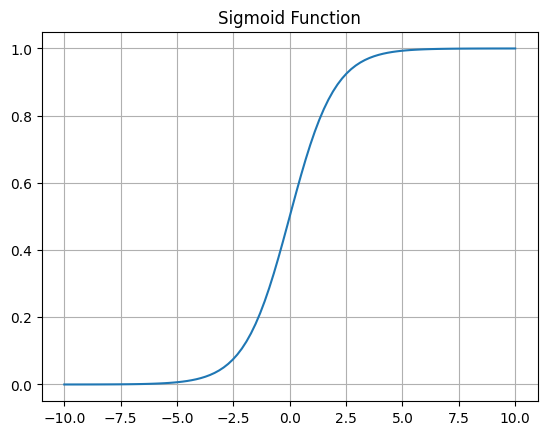

In [76]:
xs = np.linspace(-10, 10, 100)
ys = sigmoid_fun(xs)
plt.plot(xs, ys) ; plt.title('Sigmoid Function') ; plt.grid()

In [66]:
!pip3 install graphviz

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [72]:
from graphviz import Digraph
from IPython.display import display, SVG

def trace(root):
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges

def draw_dot_inline(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))
        label = f"{n.label}" if n.label else "Neuron"
        dot.node(name=uid,
                 label="{ %s | value %.4f | grad %.4f }" % (label, n.value, n.grad),
                 shape='record',
                 style='filled',
                 fillcolor='lightblue')

        if n._op:
            op_node_id = uid + n._op
            dot.node(name=op_node_id,
                     label=n._op,
                     shape='circle',
                     style='filled',
                     fillcolor='lightgray')
            dot.edge(op_node_id, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    # Display the SVG inline in Jupyter
    svg = dot.pipe(format='svg')
    display(SVG(svg))

In [175]:
class Neuron:
    def __init__(self, value, _children=(), op='', label=''):
        self.value = value
        self.grad = 0.0   # partial derivative wrt final output (L in below example)
        self._prev = set(_children)
        self._op = op
        self.label = label
        self._backward = lambda: None

    def __repr__(self):
        return f"Neuron(value={self.value}, op='{self._op}', label='{self.label}' , grad={self.grad})"

    def __add__(self, other):
        other = other if isinstance(other, Neuron) else Neuron(other)
        out = Neuron(self.value + other.value, (self, other), op='+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out   

    def __sub__(self, other):
        other = other if isinstance(other, Neuron) else Neuron(other)
        out = Neuron(self.value - other.value, (self, other), op='-')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad -= 1.0 * out.grad
            
        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Neuron) else Neuron(other)
        out = Neuron(self.value * other.value, (self, other), op='*')
        
        def _backward():
            self.grad += other.value * out.grad
            other.grad += self.value * out.grad
        out._backward = _backward
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers"
        out = Neuron(self.value ** other, (self,), op=f'**{other}')
        
        def _backward():
            self.grad += other * (self.value ** (other - 1)) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Neuron(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out
    
    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)

    def __radd__(self, other): # other + self
        return self + other


    def sigmoid(self):
        out = Neuron(sigmoid_fun(self.value), (self,), op='sigmoid')
        
        def _backward():
            self.grad += sigmoid_derivative(self.value) * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        out = Neuron(np.tanh(self.value), (self,), op='tanh')
        
        def _backward():
            self.grad += (1 - out.value ** 2) * out.grad
        out._backward = _backward
        return out
    
    # topological sort
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            # print(" >>> topo on node:", node)
            node._backward()
            

 >>> topo on node: Neuron(value=6, op='+', label='l21' , grad=1.0)
 >>> topo on node: Neuron(value=4, op='', label='l11' , grad=1.0)
 >>> topo on node: Neuron(value=2, op='', label='l12' , grad=1.0)
Neuron(value=6, op='+', label='l21' , grad=1.0)


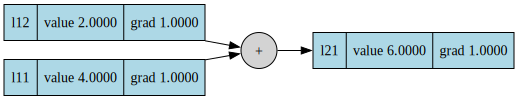

In [98]:
l11 = Neuron(4, label='l11')
l12 = Neuron(2, label='l12')

l21 = l11+l12 ; l21.label ='l21'

l21.backward()
print(l21)

draw_dot_inline(l21)


 >>> topo on node: Neuron(value=0.7421375697950144, op='tanh', label='L' , grad=1.0)
 >>> topo on node: Neuron(value=0.9552209500852817, op='-', label='l41' , grad=0.4492318274987501)
 >>> topo on node: Neuron(value=1.254, op='', label='l31' , grad=0.4492318274987501)
 >>> topo on node: Neuron(value=0.29877904991471826, op='**-0.2', label='l32' , grad=-0.4492318274987501)
 >>> topo on node: Neuron(value=420, op='+', label='l21' , grad=6.39147898150139e-05)
 >>> topo on node: Neuron(value=20, op='', label='l12' , grad=6.39147898150139e-05)
 >>> topo on node: Neuron(value=400, op='', label='l11' , grad=6.39147898150139e-05)
Neuron(value=0.7421375697950144, op='tanh', label='L' , grad=1.0)


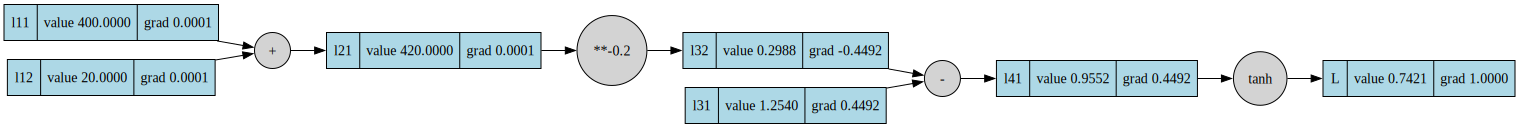

In [105]:
l11 = Neuron(400, label='l11')
l12 = Neuron(20, label='l12')
l13 = Neuron(-50.45, label='l13')
l14 = Neuron(20.15, label='l14')


l21 = l11+l12 ; l21.label ='l21'
l22 = l13*l14 ; l22.label ='l22'


l31 = Neuron(1.254, label='l31')
l32 = l21**(-0.2) ; l32.label ='l32'

l41 = l31 - l32 ; l41.label ='l41'

L = l41.tanh() ; L.label ='L'

# backpropagate
L.backward()

print(L)

draw_dot_inline(L)

## Backpropagation on a system of variables: understanding partial derivatives and chain rule

Neuron(value=-0.9640275800758169, op='tanh', label='y' , grad=1.0)


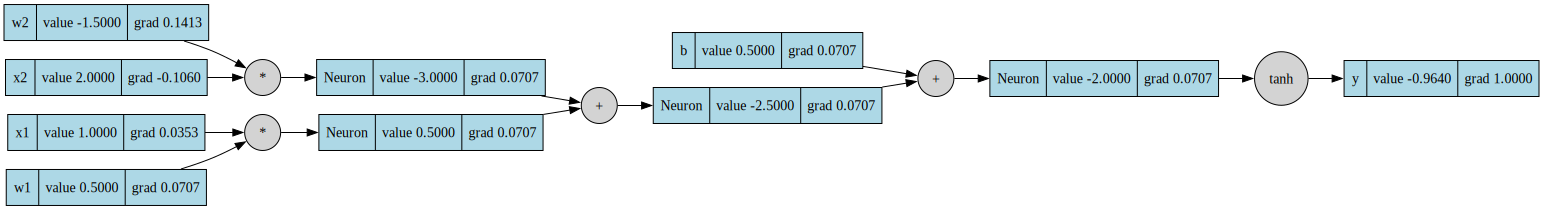

In [133]:
x1 = Neuron(1.0, label='x1')
x2 = Neuron(2.0, label='x2')

w1 = Neuron(0.5, label='w1')
w2 = Neuron(-1.5, label='w2')

b = Neuron(0.5, label='b')

y = x1*w1 + x2*w2 + b 
y = y.tanh() ; y.label = 'y'
y.backward()
print(y)
draw_dot_inline(y)

## A more complex example

In [ ]:
'''
Neural Network


Input Layer (x1)       Hidden Layer (x2)      Hidden Layer (x3)         Output
 ┌────┐                  ┌────┐                  ┌────┐                  ┌────┐
 │x1[0]──┐               │x2[0]──┐               │x3[0]──┐               │    │
 │x1[1]──┼──┐            │x2[1]──┼──┐            │x3[1]──┼──┐            │ L  │
 │x1[2]──┼──┼──┐         │x2[2]──┼──┼──┐         └────┘  │  └───────────▶│    │
 │x1[3]──┼──┼──┼──┐      └────┘  │  │                    │               └────┘
 │x1[4]──┼──┼──┼──┼──┐           │  │                    │
 └───────┘  │  │  │  │           ▼  ▼                    ▼
           b1[5]      ──▶   tanh() activation       w3, b3 used
           tanh()     ──▶   weights w2[3×5]         to compute x3[2]
           output     ──▶   bias b2[3]              then sent to L


'''

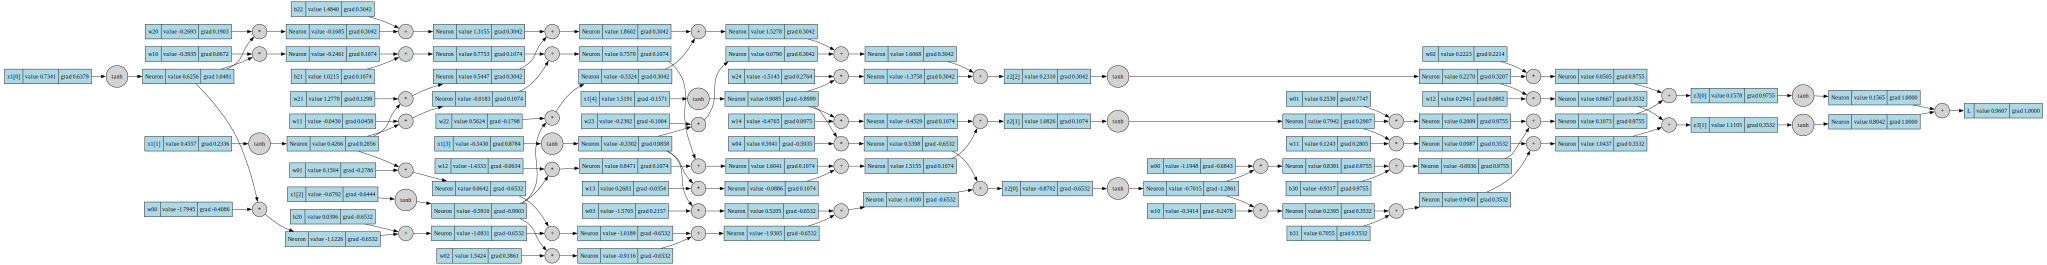

In [108]:
# Helper to make weights and biases
def neuron_matrix(m, n):
    return [[Neuron(np.random.randn(), label=f'w{i}{j}') for j in range(n)] for i in range(m)]

def bias_vector(n, name='b'):
    return [Neuron(np.random.randn(), label=f'{name}{i}') for i in range(n)]

# Layer 1 input (x1) — 5 neurons
x1 = [Neuron(np.random.randn(), label=f'x1[{i}]') for i in range(5)]

# Layer 1 output → tanh activated
x1_out = [n.tanh() for n in x1]

# Layer 2: 3 neurons, with weights w2[3][5] and bias b2[3]
w2 = neuron_matrix(3, 5)
b2 = bias_vector(3, name='b2')

x2 = []
for i in range(3):
    z = sum((w2[i][j] * x1_out[j] for j in range(5)), b2[i])
    z.label = f'z2[{i}]'
    x2.append(z.tanh())

# Layer 3: 2 neurons, weights w3[2][3], bias b3[2]
w3 = neuron_matrix(2, 3)
b3 = bias_vector(2, name='b3')

x3 = []
for i in range(2):
    z = sum((w3[i][j] * x2[j] for j in range(3)), b3[i])
    z.label = f'z3[{i}]'
    x3.append(z.tanh())

# Final output: Node L (sum of last layer)
L = x3[0] + x3[1]
L.label = 'L'

# Backprop through the graph
L.backward()

# Visualize with graphviz
draw_dot_inline(L)

# Doing the same with pytorch

In [113]:
!pip3 install torch torchviz

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [130]:
import torch

x1 = torch.Tensor([2.0,]).double() ; x1.requires_grad = True
x2 = torch.Tensor([3.0,]).double() ; x2.requires_grad = True

w1 = torch.Tensor([0.5,]).double() ; w1.requires_grad = True
w2 = torch.Tensor([0.25,]).double() ; w2.requires_grad = True

b = torch.Tensor([0.1,]).double() ; b.requires_grad = True

L = x1 * w1 + x2 * w2 + b
L = L.tanh()
print(x1)

L.backward()

print(' x1.grad:', x1.grad.item())
print(' x2.grad:', x2.grad.item())
print(' w1.grad:', w1.grad.item())
print(' w2.grad:', w2.grad.item())
print('   b.grad:', b.grad.item())

tensor([2.], dtype=torch.float64, requires_grad=True)
 x1.grad: 0.047089816376794345
 x2.grad: 0.023544908188397173
 w1.grad: 0.18835926550717738
 w2.grad: 0.28253889826076606
   b.grad: 0.09417963275358869


# 2. Building Neural Network from Scratch

In [183]:
class MyNeuron:
  
  def __init__(self, nin):
    self.w = [Neuron(np.random.randn()) for _ in range(nin)]
    self.b = Neuron(np.random.randn())
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]
  
  
class Layer:
  def __init__(self, n_in, n_out):
    self.neurons = [MyNeuron(n_in) for _ in range(n_out)]
  
  def __call__(self, x):
    # pass input to each neuron
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]
  
class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]
  

Neuron(value=-0.7996869144065025, op='tanh', label='' , grad=0.0)


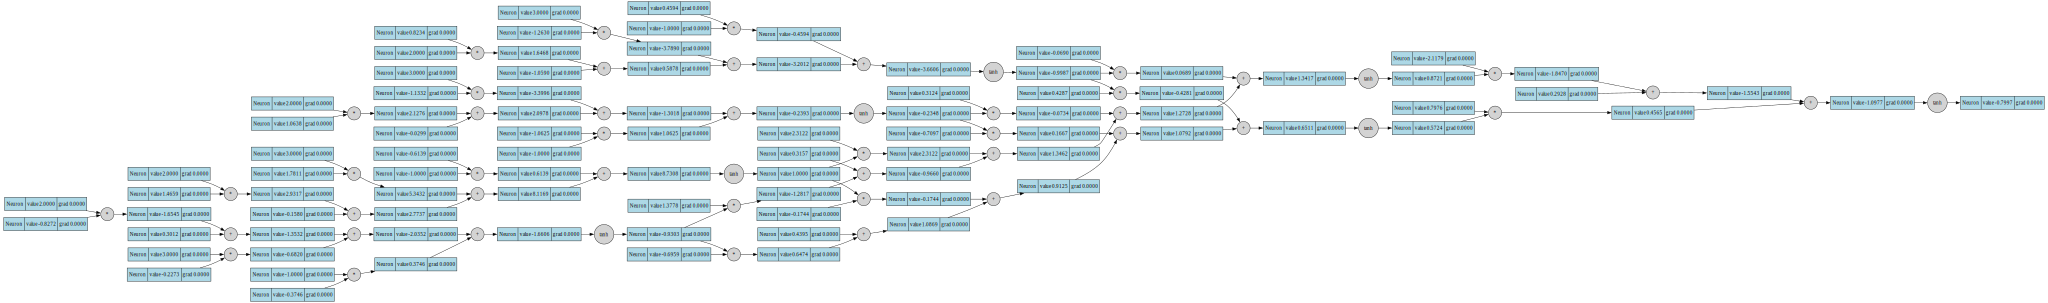

In [184]:
# x = [2.0, 3.0]
# nn = Layer(2, 3)
# nn(x)

x = [2.0, 3.0, -1.0]
nn = MLP(3, [4, 2, 1])
print(nn(x))
draw_dot_inline(nn(x))

## Simple backpropagation demo

In [211]:
nn = MLP(3, [4, 2, 1])

# input
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]

# ground truth (y_target)
ys = [1.0, -1.0, -1.0, 1.0] 

# model prediction(MLP)
ypred = [nn(x) for x in xs]
print(ypred)

# loss function
def mse_loss(y_pred, y_target):
    return sum((yp - yt)**2 for yp, yt in zip(y_pred, y_target)) / len(y_pred)
# loss
loss = mse_loss(ypred, ys)
print('loss:', loss)


# backprop
loss.backward()

nn.layers[0].neurons[0].w[0].grad


[Neuron(value=0.011733034562682142, op='tanh', label='' , grad=0.0), Neuron(value=-0.26189774815813305, op='tanh', label='' , grad=0.0), Neuron(value=-0.33008468438672206, op='tanh', label='' , grad=0.0), Neuron(value=-0.6136841510945866, op='tanh', label='' , grad=0.0)]
loss: Neuron(value=1.1435573996839536, op='*', label='' , grad=0.0)


np.float64(0.45084103410629844)

In [191]:
print(nn.layers[0].neurons[0].w[0].grad)
print(nn.layers[0].neurons[0].w[0].value)
nn.parameters()

0.04464513114696337
1.436706714916101


[Neuron(value=1.436706714916101, op='', label='' , grad=0.04464513114696337),
 Neuron(value=-1.9647967881275685, op='', label='' , grad=0.030728501704107288),
 Neuron(value=1.8259496074155113, op='', label='' , grad=-0.0872748696441224),
 Neuron(value=1.2182503906706024, op='', label='' , grad=0.029849118163107927),
 Neuron(value=-0.37840155542162196, op='', label='' , grad=0.5575836642967222),
 Neuron(value=-0.4478777817344813, op='', label='' , grad=0.03874585494453828),
 Neuron(value=0.8371473610969303, op='', label='' , grad=0.3151397964142383),
 Neuron(value=-0.015648633561999456, op='', label='' , grad=0.35456254624845923),
 Neuron(value=0.7357816693406115, op='', label='' , grad=-0.21583020251797974),
 Neuron(value=0.43917828955066573, op='', label='' , grad=0.12568058707027388),
 Neuron(value=-1.0030379138738486, op='', label='' , grad=-0.10920330681968925),
 Neuron(value=-1.4737292489162768, op='', label='' , grad=-0.052932210006472746),
 Neuron(value=-2.870511182621923, op=''

In [225]:
# STEP1: forward pass ⭐️
ypred = [nn(x) for x in xs]
loss = mse_loss(ypred, ys)
print('loss:', loss)

loss: Neuron(value=0.784557204724327, op='*', label='' , grad=0.0)


In [224]:
# STEP2: backprop (backward pass)  ⭐️
loss.backward()

In [223]:
# STEP3 : gradient descent (update weights) ⭐️
learning_rate = 0.01
for p in nn.parameters():
    p.value -= learning_rate * p.grad
    p.grad = 0.0

In [226]:
ypred

[Neuron(value=0.43964043898961325, op='tanh', label='' , grad=0.0),
 Neuron(value=-0.25638559434912683, op='tanh', label='' , grad=0.0),
 Neuron(value=-0.37411486575485825, op='tanh', label='' , grad=0.0),
 Neuron(value=-0.3709600270325151, op='tanh', label='' , grad=0.0)]

In [232]:
'''
Training MLP on 20 epochs  ⭐️ ⭐️ ⭐️ ⭐️ ⭐️ ⭐️ ⭐️ ⭐️
'''

for k in range(20):
  
  # forward pass
  ypred = [nn(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  ## flush gradients, so that they don't accumulate
  for p in nn.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in nn.parameters():
    p.value += -0.05 * p.grad
  
  print(k, loss.value)
  

0 0.0054600095038494344
1 0.005411715633209729
2 0.005364273492834254
3 0.005317660563911442
4 0.005271855121357365
5 0.0052268361988631025
6 0.005182583555786735
7 0.005139077645776357
8 0.005096299587019015
9 0.005054231134017383
10 0.005012854650802837
11 0.004972153085499909
12 0.004932109946162764
13 0.00489270927780957
14 0.004853935640585786
15 0.004815774088991476
16 0.0047782101521126686
17 0.004741229814799942
18 0.004704819499741638
19 0.004668966050381914


## Using pytorch

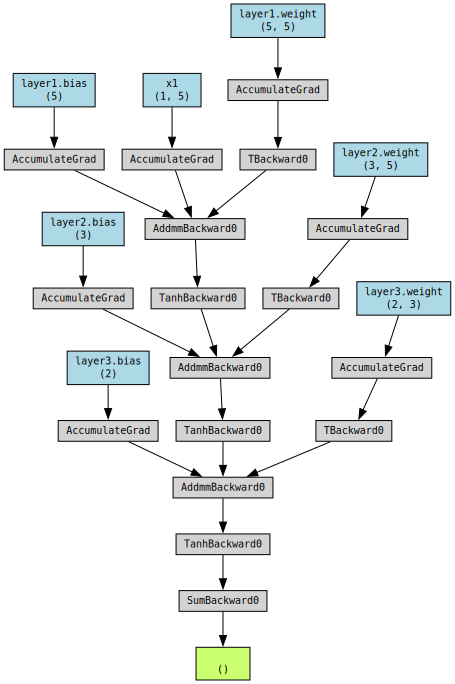

In [116]:
import torch
import torch.nn as nn
from torchviz import make_dot
from IPython.display import display

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(5, 5)
        self.layer2 = nn.Linear(5, 3)
        self.layer3 = nn.Linear(3, 2)
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        x1 = self.tanh(self.layer1(x))
        x2 = self.tanh(self.layer2(x1))
        x3 = self.tanh(self.layer3(x2))
        return torch.sum(x3)

# Create model and input
model = MLP()
x1 = torch.randn(1, 5, requires_grad=True)

# Forward and backward pass
output = model(x1)
output.backward()

# Create and display the graph
dot = make_dot(output, params=dict(list(model.named_parameters()) + [('x1', x1)]))
display(dot)